In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd

# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [3]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [5]:
# Inspect the data
y.head()

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K


In [7]:
# Check for missing values in the features
X.isnull().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64

# Data Cleaning

### Handling missing values and "?"

In [11]:
import numpy as np
# Replace "?" with NaN in the specified columns using .loc
X.loc[X['workclass'] == "?", 'workclass'] = np.nan
X.loc[X['occupation'] == "?", 'occupation'] = np.nan
X.loc[X['native-country'] == "?", 'native-country'] = np.nan

# Impute missing values with the most frequent value (mode) using .loc[]
X.loc[:, 'workclass'] = X['workclass'].fillna(X['workclass'].mode()[0])
X.loc[:, 'occupation'] = X['occupation'].fillna(X['occupation'].mode()[0])
X.loc[:, 'native-country'] = X['native-country'].fillna(X['native-country'].mode()[0])

In [13]:
# Standardize original categorical columns
X.loc[:, 'native-country'] = X['native-country'].str.lower()

In [15]:
X.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64

### One hot encoding

In [18]:
# Perform one-hot encoding for categorical features
X = pd.get_dummies(X, columns=['workclass', 'education', 'marital-status', 'occupation',
                                          'relationship', 'race', 'sex', 'native-country'], drop_first=True)

### Ensuring correct data types

In [21]:
X.loc[:, 'age'] = X['age'].astype(int)
X.loc[:, 'fnlwgt'] = X['fnlwgt'].astype(int)
X.loc[:, 'capital-gain'] = X['capital-gain'].astype(int)
X.loc[:, 'capital-loss'] = X['capital-loss'].astype(int)
X.loc[:, 'hours-per-week'] = X['hours-per-week'].astype(int)

In [23]:
# Check the data types of the columns
X.dtypes

age                               int64
fnlwgt                            int64
education-num                     int64
capital-gain                      int64
capital-loss                      int64
                                  ...  
native-country_thailand            bool
native-country_trinadad&tobago     bool
native-country_united-states       bool
native-country_vietnam             bool
native-country_yugoslavia          bool
Length: 97, dtype: object

### Feature engineering

In [26]:
# Create a new feature 'net-capital-gain'
X['net-capital-gain'] = X['capital-gain'] - X['capital-loss']
# Drop the original 'capital-gain' and 'capital-loss' columns if no longer needed
X.drop(['capital-gain', 'capital-loss'], axis=1, inplace=True)

In [28]:
# Drop `education-num` since it seems redundant
X.drop('education-num', axis=1, inplace=True)

### Handling outliers

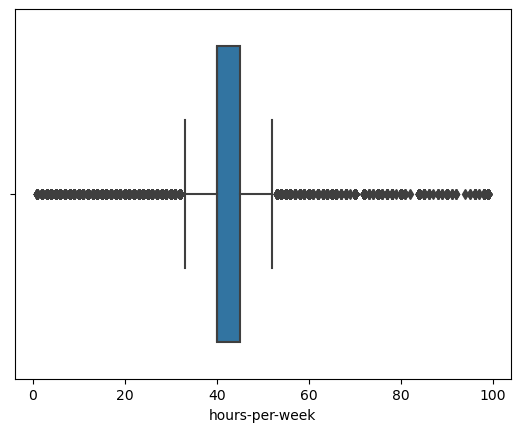

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot to check for outliers in 'hours-per-week'
sns.boxplot(x=X['hours-per-week'])
plt.show()

In [33]:
# Function to remove outliers based on IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        # Calculate IQR
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for detecting outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove rows where values are outside the bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Columns to check for outliers (adjust as needed)
columns_to_check = ['age', 'fnlwgt', 'net-capital-gain', 'hours-per-week']

# Apply the function to remove outliers
X_cleaned = remove_outliers_iqr(X, columns_to_check)

# Display the cleaned dataframe
X_cleaned.head()

,age,fnlwgt,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,...,native-country_puerto-rico,native-country_scotland,native-country_south,native-country_taiwan,native-country_thailand,native-country_trinadad&tobago,native-country_united-states,native-country_vietnam,native-country_yugoslavia,net-capital-gain
2,38,215646,40,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,0
3,53,234721,40,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,0
4,28,338409,40,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
5,37,284582,40,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,0
7,52,209642,45,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,0


In [35]:
X_cleaned['hours-per-week'].max()

52

In [37]:
print(X_cleaned.shape)
print(y.shape)

(29656, 95)
(48842, 1)


In [39]:
# Assuming y is still a pandas Series, you can check:
y = y.loc[X_cleaned.index]

In [41]:
print(X_cleaned.shape)
print(y.shape)

(29656, 95)
(29656, 1)


In [43]:
#Deleting incorrect entries
y = y.replace({"<=50K.": "<=50K", ">50K.": ">50K"})

### Support Vector Machine

In [46]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)

In [48]:
#Scaling Features with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
# Create the SVM classifier
classifier = SVC(kernel='linear')
# Fit the classifier
classifier.fit(X_train_scaled, y_train.values.ravel()) 

SVC(kernel='linear')

In [52]:
# predict the labels for the scaled test
prediction = classifier.predict(X_test_scaled)

In [54]:
#Created DataFrame to compare the predicted labels
results_df = pd.DataFrame({"Prediction": prediction, "Actual": y_test.values.ravel()})  # Ensure y_test is 1D
results_df

,Prediction,Actual
0,<=50K,<=50K
1,<=50K,<=50K
2,<=50K,<=50K
3,<=50K,<=50K
4,<=50K,<=50K
...,...,...
5927,<=50K,<=50K
5928,<=50K,<=50K
5929,<=50K,<=50K
5930,<=50K,<=50K


In [56]:
from sklearn.metrics import confusion_matrix
#Generated confusion matrix
conf_mx = confusion_matrix(y_test.values.ravel(), prediction)  # Ensure y_test is 1D
conf_mx_df = pd.DataFrame(
    conf_mx, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
conf_mx_df

,Predicted 0,Predicted 1
Actual 0,4471,259
Actual 1,690,512


In [58]:
from sklearn.metrics import classification_report
# Print the classification report for the model
print("Classification Report")
print(classification_report(y_test.values.ravel(), prediction))  # Ensure y_test is 1D

Classification Report
              precision    recall  f1-score   support

       <=50K       0.87      0.95      0.90      4730
        >50K       0.66      0.43      0.52      1202

    accuracy                           0.84      5932
   macro avg       0.77      0.69      0.71      5932
weighted avg       0.83      0.84      0.83      5932



### Visualization

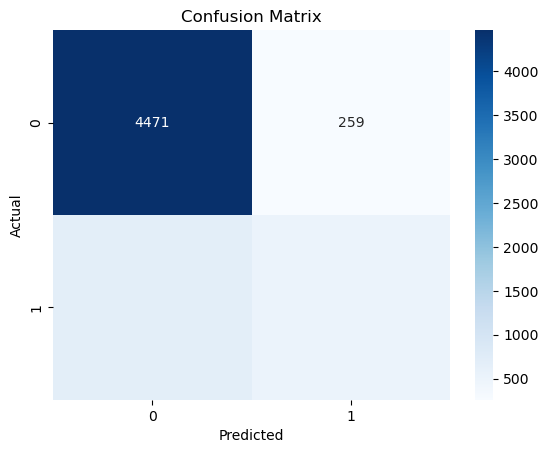

In [99]:
cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

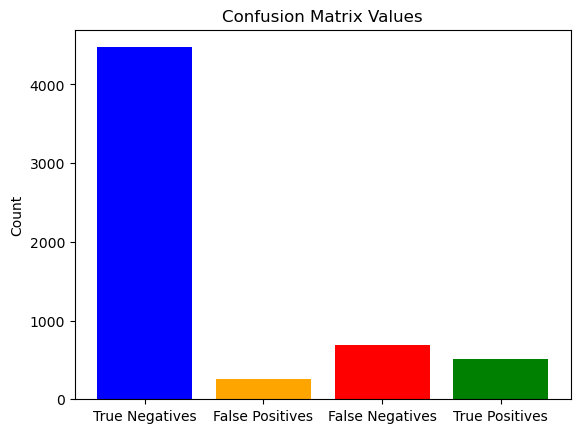

In [77]:
# Extract values from the confusion matrix
tn, fp, fn, tp = conf_mx.ravel()
# Create a bar plot
labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
values = [tn, fp, fn, tp]
plt.bar(labels, values, color=['blue', 'orange', 'red', 'green'])
plt.title('Confusion Matrix Values')
plt.ylabel('Count')
plt.show()